In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
import tensorflow as tf
from scipy.stats import t
from scipy.stats import norm
from tensorflow.keras import backend as K

In [3]:
np.random.seed(58)
n_samples = 3000
nn = 'uniform' #Select 'uniform' or 'normal' for artificial data generation.
if nn == 'uniform':
  noise = np.random.uniform(low=-1,high=1,size=n_samples)
  X = np.random.uniform(low=-2*np.pi,high=2*np.pi,size=(n_samples,1))
  y = (np.sin(X[:,0])/X[:,0]) + noise
  y_ = (np.sin(X[:,0])/X[:,0])
  X_train = X.reshape(-1)
  y_train = y.reshape(-1)
  y_train = np.stack((y_train,y_train),axis=1)
  x_grid = np.linspace(-6,6,3000)


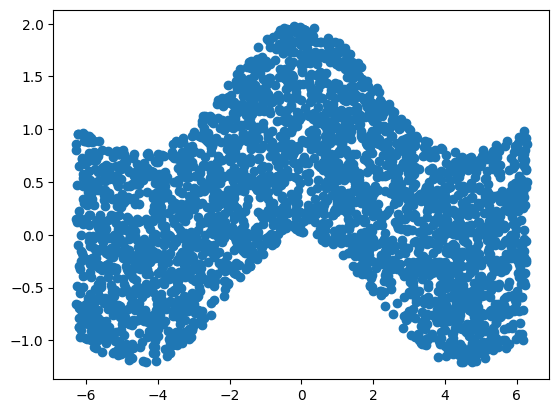

In [4]:
plt.scatter(X_train,y_train[:,0])

In [5]:
# hyperparameters for Tube Loss
q = 0.95 # target coverage
r=0.5  # for movement of PI tube
delta = 0 #  for recalibration


def confidence_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    # Use tf.where to create a tensor based on conditions
    loss_part1 = tf.where(y_true > r * (f1 + f2), c1, c2)
    loss_part2 = tf.where(f1 > y_true, c3, c4)

    final_loss = tf.where(tf.logical_and(y_true <= f2, y_true >= f1), loss_part1, loss_part2) + (delta * tf.abs(f1 - f2))

    # Reduce the loss to a scalar using tf.reduce_mean
    return tf.reduce_mean(final_loss)

In [6]:

# hyperparameters for QD Loss
lambda_ = 0.01 # lambda in loss fn
alpha_ = 0.05  # capturing (1-alpha)% of samples
soften_ = 255.  # Approximation
def qd_objective(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    y_true = y_true[:,0]
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)

    Loss_S = MPIW_c + lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)

    return Loss_S

In [7]:
# set up model
l=2    # Select loss function using this parameter; l=2 is Tube Loss ; l =1 is QD loss
n_ = 100 # batch size
model = Sequential()
model.add(Dense(100, input_dim=1, activation='relu',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
model.add(Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))) # important to init biases to start!

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
if l==1:
  loss=qd_objective
else:
  loss=confidence_loss
model.compile(loss=loss, optimizer=opt)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


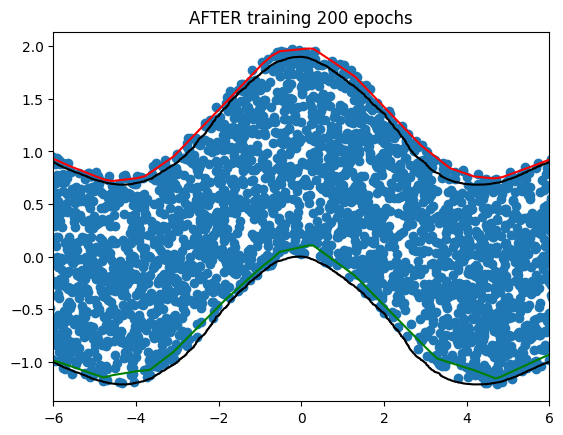

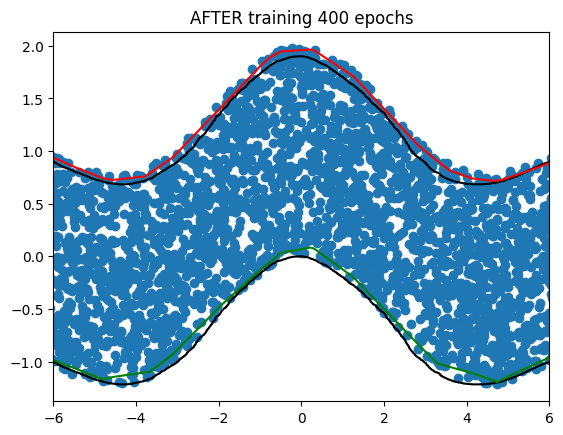

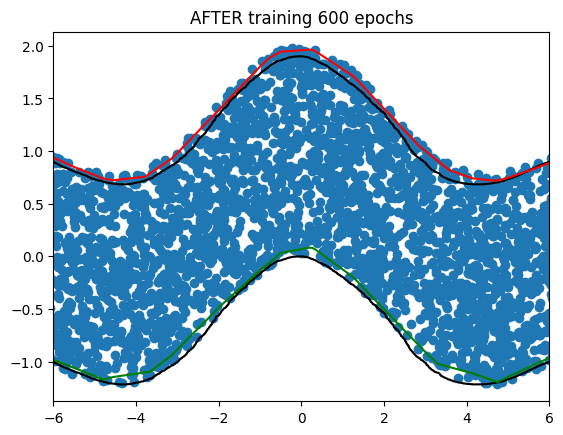

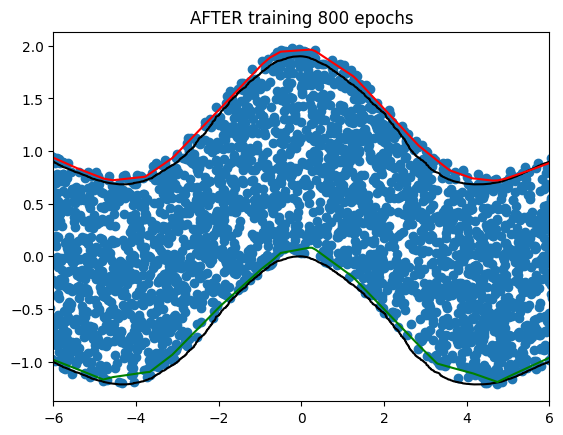

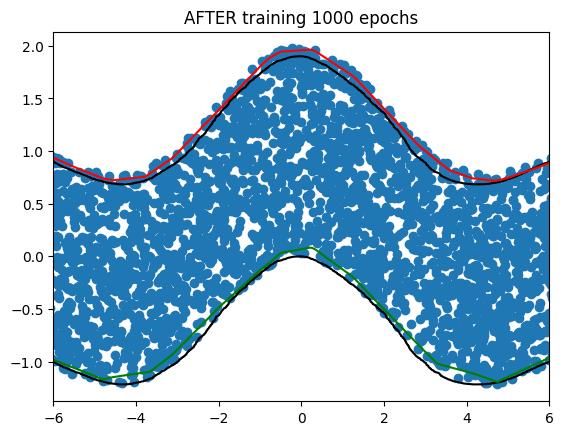

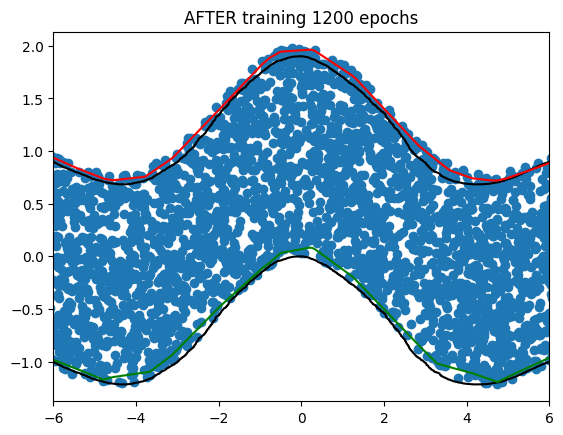

In [8]:
result_loss=[]
idx = np.argsort(X[:,0])
if nn == 'uniform':
  y_u_pred_ = (np.sin(X[idx])/X[idx]) + 0.9  #  Upper bound of True PI
  y_l_pred_ = (np.sin(X[idx])/X[idx]) - 1    # Lower bound of True PI

for i in range(6):
    result = model.fit(X_train, y_train, epochs=200, batch_size=n_, verbose=0,  validation_split=0.)
    result_loss.append(result.history['loss'])

    # plot and view some predictions
    y_pred = model.predict(x_grid, verbose=0)
    y_u_pred = y_pred[:,0]
    y_l_pred = y_pred[:,1]

    plt.scatter(X_train,y_train[:,0])
    plt.plot(x_grid, y_u_pred_, color='black') # upper boundary prediction of True PI
    plt.plot(x_grid, y_l_pred_, color='black') # lower boundary prediction of True PI
    plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction of estimated PI
    plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction  of estimated PI
    plt.title('AFTER training '+str((i+1)*200)+' epochs')
    if nn=='uniform':
      plt.xlim(-6,6)
    if nn == 'normal':
      plt.xlim(-2,2)
    plt.show()

In [9]:
# Calculating Evaluation Criteria
y_pred = model.predict(X_train, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > y_train[:,0]
K_l = y_l_pred < y_train[:,0]
print('PICP:', np.mean(K_u * K_l))
print('MPIW:', np.round(np.mean(y_u_pred - y_l_pred),3))

PICP: 0.9503333333333334
MPIW: 1.89


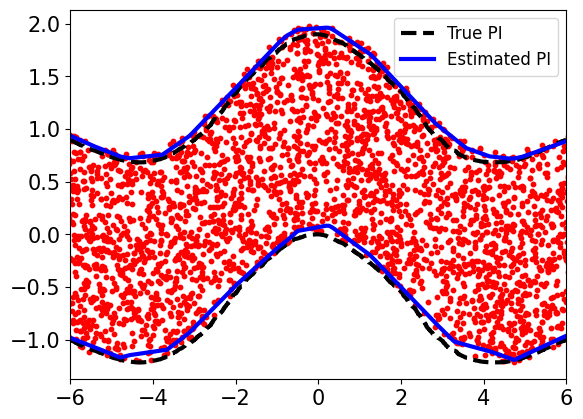

In [10]:
#Visualizing Final Result
plt.scatter(X_train,y_train[:,0],s=10,c='r')
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
plt.plot(x_grid, y_u_pred_, color='black',linestyle='dashed',linewidth=3,label='True PI') # upper boundary prediction
plt.plot(x_grid, y_l_pred_, color='black',linestyle='dashed',linewidth=3) # lower boundary prediction
plt.plot(x_grid, y_u_pred, color='b',linewidth=3,label='Estimated PI') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='b',linewidth=3) # lower boundary prediction
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize="12",loc=1)
if nn=='uniform':
  plt.xlim(-6,6)
if nn == 'normal':
  plt.xlim(-2,2)
plt.show()